In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
from scipy import integrate

From the WCRP assessment, Eq. (4.3) is 

$$\Delta T_{obs} = S_{hist} \frac{(\Delta F - \Delta N)}{F_{2\times CO_2}} + e$$ 

In [2]:
nsamp=1000000 #change as needed
dT_error = np.random.normal(loc=0.00,scale=0.14/1.64,size=nsamp) #Assume error in dT is normally distributed
dT=1.0
dN = np.random.normal(0.60,0.3/1.64,size=nsamp)
F2x = np.random.normal(3.7,0.49/1.64,size=nsamp)


To allow for the correlation between CO$_2$ forcing part of $\Delta F$ and $F_{2\times CO_2}$ we decompose $\Delta F$ into its CO$_2$ and non-CO$_2$ constituent time series, and sample the latter independently of $F_{2\times CO_2}$ before recombining to obtain the samples $\Delta F$.  This means we need to know exactly what the CO2 and non-CO2 forcings were over this time period.  I use the values in hist_forc_out.txt, generated by Mark Webb using subroutine hist_forc, and put these in a python dictionary.

In [3]:
f=open("hist_forc_out.txt")
test=f.readlines()
f.close()

In [4]:
dF_CO2=float(test[-1].split(":")[-1])
rest=np.array(test[:-1])
baselines=rest[::5]
recents=rest[1::5]
unc_pos=rest[2::5]
unc_neg=rest[3::5]
other_forcings=[x.split("baseline")[0] for x in baselines]
forcing_dict={}
for i in range(len(other_forcings)):
    key=other_forcings[i]
    forcing_dict[key]={}
    devs=np.random.normal(0,1.0,size=nsamp)
    devscaled=np.zeros_like(devs)
    sigma_pos=float(unc_pos[i].split(":")[-1])
    forcing_dict[key]["sigma_pos"]=sigma_pos
    devscaled[np.where(devs>=0)]=devs[np.where(devs>=0)]*sigma_pos

    sigma_neg=float(unc_neg[i].split(":")[-1])
    forcing_dict[key]["sigma_neg"]=sigma_neg
    devscaled[np.where(devs<0)]=devs[np.where(devs<0)]*sigma_neg
    
    baseline=float(baselines[i].split(":")[-1])
    forcing_dict[key]["baseline"]=baseline
    
    recent=float(recents[i].split(":")[-1])
    forcing_dict[key]["recent"]=recent
    forcing_dict[key]["deviations"] = (recent-baseline)*(1+devscaled)#just for plotting
    
    
    
    

In [5]:
plt.figure()
forcing_dict.keys()
#tmp=plt.hist(forcing_dict["Other WMGHG "]["deviations"])

dict_keys(['Other WMGHG ', 'O3 (T) ', 'O3(S) ', 'total aerosol ERF ', 'ERF LUC ', 'Vapour ', 'BC snow ', 'contrails ', 'Solar ', 'Volcanic '])

<Figure size 432x288 with 0 Axes>

In [6]:
def generate_dF():
    all_forcings=np.zeros((len(other_forcings),nsamp))
    i=0
    for key in other_forcings:
        devs=np.random.normal(0,1.0,size=nsamp)
        devscaled=np.zeros_like(devs)
        devscaled[np.where(devs>=0)]=devs[np.where(devs>=0)]*forcing_dict[key]["sigma_pos"]
        devscaled[np.where(devs<0)]=devs[np.where(devs<0)]*forcing_dict[key]["sigma_neg"]
        
        all_forcings[i]= (forcing_dict[key]["recent"]-forcing_dict[key]["baseline"])*(1+devscaled)
        i+=1
    return np.sum(all_forcings,axis=0)

Sanity check: do the scaled forcing distributions look OK?

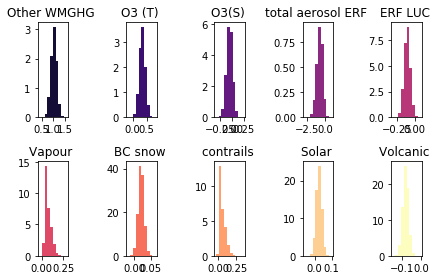

In [7]:
counter=1
for key in other_forcings:
    plt.subplot(2,5,counter)
    plt.hist(forcing_dict[key]["deviations"],density=True,color=cm.magma(counter/10.))
    plt.title(key)
    counter+=1
plt.tight_layout()

In [40]:
afcing=forcing_dict['total aerosol ERF ']['deviations']


Now check to make sure the distribution of all forcings looks OK:

F other mean =  0.6036441697845254
Delta F =  2.2197132875753103
5th percentile is 1.4162374379122948
95th percentile is 2.913275549877571


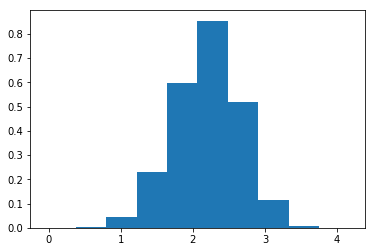

In [8]:
plt.figure()

dF_other=generate_dF()
n,bins,patches=plt.hist(dF_other+dF_CO2,density=True)
print("F other mean = ",np.average(dF_other))
print("Delta F = ",np.median(dF_CO2+dF_other))
print("5th percentile is", np.percentile(dF_CO2+dF_other,5))
print("95th percentile is", np.percentile(dF_CO2+dF_other,95))

For a putative value of $S_{hist}$, the energy balance model dictates a distribution of $\Delta T_{model}$.  We can compare this to the actual observed temperature change $\Delta T = 1 K$.  

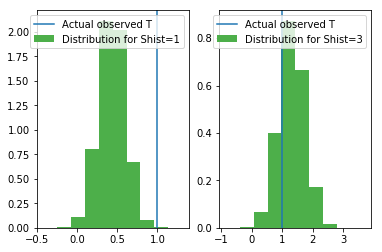

In [9]:
Shist=1.
dF_other=generate_dF()
values=Shist*(dF_CO2+dF_other-dN)/F2x + dT_error
plt.subplot(1,2,1)
n,bins,patches=plt.hist(values,color=cm.Set1(.3),density=True,label="Distribution for Shist=1")
plt.axvline(dT,label="Actual observed T")
plt.legend()

Shist=3.
dF_other=generate_dF()
values=Shist*(dF_CO2+dF_other-dN)/F2x + dT_error
plt.subplot(1,2,2)
n,bins,patches=plt.hist(values,color=cm.Set1(.3),density=True,label="Distribution for Shist=3")
plt.axvline(dT,label="Actual observed T")
plt.legend()

From this, we can see that $S_{hist}=3$ is more likely than $S_{hist}=1$, because the observed $\Delta T$ lies closer to the center of the resulting $\Delta T_{model}$ distribution.  Now, we loop over possible values of $S_{hist}$ and calculate the resulting likelihood, defined as the kernel density of Monte Carlo samples of $\Delta T_{model}$ evaluated at $\Delta T_{obs} = 1.0 K$.

In [10]:
nbins=int(nsamp/10)
Shist_values=np.linspace(0,20,nbins)
likelihood=[]
for Shist in Shist_values:
    
    
    #dF_other=generate_dF() #Do we need to re-sample DF, DT_error, DN every time?
    
    values=Shist*(dF_CO2+dF_other-dN)/F2x + dT_error
    kde = stats.gaussian_kde(values) 
    likelihood+=[float(kde(dT))]
likelihood=likelihood/np.max(likelihood)

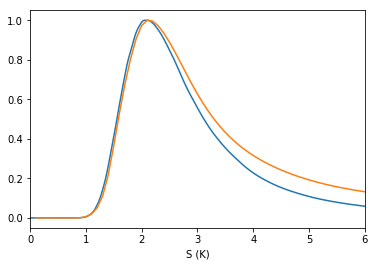

In [53]:
plt.figure()
plt.plot(Shist_values,likelihood)
set_limits=plt.xlim(0,6)
xlab=plt.xlabel("S (K)")
import pickle
fpickle=open("IntegralLikelihood.p","rb")
d=pickle.load(fpickle)
x=S_possibilities=np.arange(0,10,.1) 
y=d["likelihood"]
y=np.ma.masked_where(np.isnan(y),y)
plt.plot(x,y/np.max(y))


In [12]:
print("The most likely value of S_hist is "+ str(Shist_values[np.argmax(likelihood)]))

The most likely value of S_hist is 2.093820938209382


In [13]:
samples=np.random.choice(Shist_values,size=10000,p=likelihood/np.sum(likelihood),replace=True)
interpolation = "nearest"
print("5th percentile",np.percentile(samples, 5, interpolation=interpolation),)
print("50th percentile",np.percentile(samples, 50, interpolation=interpolation),)
print("95th percentile",np.percentile(samples, 95, interpolation=interpolation),)

5th percentile 1.5712157121571217
50th percentile 2.641826418264183
95th percentile 7.639276392763928


In [14]:
#Test for dT: inflate uncertainty in dT with uncertainty in F2x (assume uncorrelated)
F2x=3.7
F2x_error=np.random.normal(F2x,0.74/1.64,size=nsamp)

#plt.figure()
#tmp=plt.hist(dT,50,alpha=.5)
#tmp=plt.hist(dT*F2x_error/F2x,50,alpha=.5,density=True)

dT_with_error=dT*F2x_error/F2x

test_values=np.zeros((3,nsamp))
test_values[0]=dT_with_error
test_values[1]= np.random.normal(0.60,0.3/1.64,size=nsamp)
test_values[2]=F2x_error/F2x * dF_CO2 + generate_dF()

test_kde=stats.gaussian_kde(test_values)


def likelihood_density(S,tmin=-10,tmax=10,qmin=-10,qmax=10):
    F2x_scalar=3.7
    ru=np.array([1,0,F2x_scalar/S])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda v,u: test_kde((v,u,F2x_scalar/S*v+u))*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda v: qmin, lambda v: qmax)[0]
#test2=[likelihood_density(S,tmin=-10,tmax=10) for S in Shist_values]

In [15]:
Lambdas={}
Lambdas["planck"]=[-3.2,0.1]
Lambdas["lr+wv"]=[1.15,0.15]
Lambdas["alb"]=[0.3,0.15]
Lambdas["cld"]=[0.4,0.31]
Lambdas["comp"]=[0,0.15]
Lambdas["tot"]=[-1.35,0.41]

In [16]:
 dF

NameError: name 'dF' is not defined